In [1]:
!pip install transformers
!pip install albumentations

[[0.77453733, 0.15082821, 0.07092405, 0.08765801], [0.76905563, 0.26410751, 0.05321542, 0.06363683], [0.86604179, 0.26284224, 0.0426398, 0.06213716], [0.95390459, 0.25512594, 0.02786348, 0.04027213], [0.77816822, 0.50773345, 0.07704122, 0.08686714], [0.76291066, 0.62083333, 0.05562233, 0.08613058], [0.34770331, 0.36118083, 0.63047189, 0.09501183], [0.34506579, 0.61039417, 0.61730137, 0.08121997], [0.3436544, 0.50971343, 0.63251582, 0.09019362]]
I
1
1
1
TOTAL :
L
***
124/83
(98)


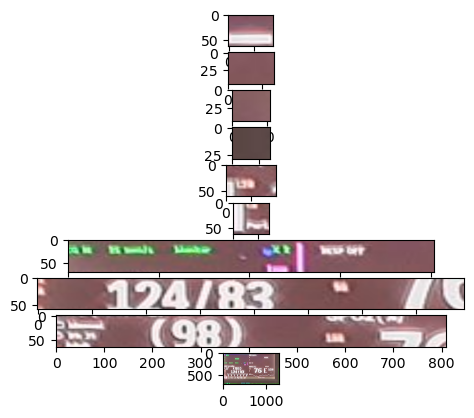

In [4]:
import unet_pred
import correct_perspective
import detector
import trocr
import os
import cv2
import matplotlib.pyplot as plt

TEST_IMG_DIR = "test_data"
imlis = os.listdir(TEST_IMG_DIR)
imloc = f"{TEST_IMG_DIR}/{imlis[9]}"

data = cv2.imread(imloc)
mask = unet_pred.maskPred(imloc)

monitor =  correct_perspective.correctPerspective(data, mask)

bounding_boxes = detector.boundingBoxes(monitor)

print(bounding_boxes)

fig, ax = plt.subplots(len(bounding_boxes) + 1)

for idx,bounding_box in enumerate(bounding_boxes):
    text, crop = trocr.trOCR(monitor, bounding_box)

    print(text)
    ax[idx].imshow(crop)
ax[-1].imshow(monitor)